In [3]:
import glob
import sys
import numpy as np
import operator
from scipy import optimize
from scipy import stats
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import RegularGridInterpolator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import os

c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

path = '/Users/agnivaghosh/Downloads/Lensing/graleruns/Irtysh/IrtyshIII/runIIIc/data/'
os.chdir(path)


plummers = np.genfromtxt('invX_plummers.dat', dtype=(
    {'names': ['x', 'y', 'width', 'mass'], 'formats': ['f8', 'f8', 'f8', 'f8']}))
px=plummers['x']
py=plummers['y']
pmass=plummers['mass']
pwidth=plummers['width']

plumno = np.genfromtxt('plum_no.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

mult = np.genfromtxt('images_combined_mult.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

img = np.genfromtxt('images_combined.out', dtype=(
    {'names': ['tag', 'x', 'y', 'z'], 'formats': ['f8', 'f8', 'f8', 'f8']}))

N = len(img['x']) #Number of images


In [4]:
def defl(image, scrit, sden, N, x, y):
    '''
    This function calculates the deflection angle at a point from a NxN grid. 
    image :: point to calculate deflection angle at
    scrit :: critical surface density at that point
    sden :: NxN grid of surface density points in units of kg/m^2
    x & y :: coordinates of grid with respect to center of cluster from Grale
    dfx & dfy :: components of deflection angle
    '''
    sd=0.1/scrit  #calculate reciprocal of critical surface density switching to kg/m^2


    #declare integrand for 2D integral
    intx,inty = np.meshgrid(x,y)
    dl=x[1]-x[0] #calculate integration step between grid points

    dfx = 0. #initialize each component of deflection angle
    dfy = 0. 

    # construct 2-D integrands
    #---------------------------------------------------------------------
    for j in range(N):
        for i in range(N):
            d = np.sqrt((image[0]-x[i])**2+(image[1]-y[j])**2)
            dfx += (image[0]-x[i])*sden[j,i]*sd/d**2/np.pi*dl*dl
            dfy += (image[1]-y[j])*sden[j,i]*sd/d**2/np.pi*dl*dl

    return dfx, dfy


################
class constants:
#---------------
	'''
	class of cosmology constants
	'''
    ##########################################
	def __init__(self, omega_m, omega_l, H_0):
    #-----------------------------------------
		self.omega_m = omega_m 					#matter density
		self.omega_l = omega_l					#dark energy density / lambda
		self.omega_k = 1.0 - omega_l - omega_m 	#curvature density, for flat normally zero
		self.H = H_0						#Hubble parameter today
		self.h = H_0/100.					#dimensionless Hubble parameter
		self.d_h = 299792.458/H_0			#Hubble distance, c/H_0 with c in units of km * s^-1


################
class distances:
#---------------
	'''
	class of different distances in cosmology
	'''
    ################################
	def codist(self, z1, z2, cosmo):
    #-------------------------------
		'''
		This function calculates the comoving distance d_c in units of Mpc.
		z1, z2 :: redshifts with z1<z2
		cosmo  :: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c    :: comoving distance
		'''
		dz = 0.0001
		z = z1 + 0.5 * dz
		d_c = 0.0
		while(z < z2):
			f = 1.0 + z
			demon = cosmo.omega_m * f**3 + cosmo.omega_k * f**2 + cosmo.omega_l
			d_c += dz / np.sqrt(demon)
			z += dz
		return d_c*cosmo.d_h
    ######################################
	def tcodist(self, z1, z2, d_c, cosmo):
    #-------------------------------------
		'''
		This function calculates the transverse comoving distance d_M in units of Mpc.
		z1, z2	:: redshifts with z1<z2
		cosmo	:: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c		:: comoving distance
		d_M		:: transverse comoving distance
		'''
		d_M = 0.0
		f = np.sqrt(np.abs(cosmo.omega_k))
		if(cosmo.omega_k > 0.0):
			d_M = cosmo.d_h/f*np.sinh(f*d_c/cosmo.d_h)
			#print 'Omega_k > 0'
		elif(cosmo.omega_k < 0.0):
			d_m = cosmo.d_h/f*np.sin(f*d_c/cosmo.d_h)
			#print 'Omega_k < 0'
		else:
			d_M = d_c
		return d_M
    ###############################
	def angdist(self, d_M, z, d_A):
    #------------------------------
		'''
		This function calculates the angular diameter distance d_M in units of Mpc.
		z1		:: redshift z
		d_M		:: transverse comoving distance
		d_A		:: angular diameter distance
		'''
		d_A = 0.0
		d_A = d_M/(1.0+z)
		return d_A

In [5]:
# First thing is to get angular diameter distances and critical surface densities for every image

#Constants
c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

# Define cosmology.
cosmo = constants(0.3, 0.7, 70)

# Define redshifts
z_o = 0.0  # observer redshift
z_l = 0.4  # lens redshift for Abell 2744

# Initialize angular diameter arrays
d_ol = np.zeros(N)
d_ls = np.zeros(N)
d_os = np.zeros(N)
scrit = np.zeros(N)

#Check Curvature is near zero
print ("Omega_k: ", cosmo.omega_k)

d_c, d_M, d_A = 0.0, 0.0, 0.0  # Initialize distances
dist = distances()  # create cosmology.distance instance

# For loop over images to calculate the angular diameter distances and critical surface densities.
for i in range(N):
    z_s = img['z'][i]

    # Calculate the observer to lens ang dist.
    d_c = dist.codist(z_o, z_l, cosmo)
    d_M = dist.tcodist(z_o, z_l, d_c, cosmo)
    d_A = dist.angdist(d_M, z_l, d_A)

    d_ol[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the lens to source ang dist.
    d_c = dist.codist(z_l, z_s, cosmo)
    d_M = dist.tcodist(z_l, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_ls[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the observer to source ang dist.
    d_c = dist.codist(z_o, z_s, cosmo)
    d_M = dist.tcodist(z_o, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_os[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    #Calculate critical surface density
    scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]
    
print(scrit)



Omega_k:  5.551115123125783e-17
[0.43037304 0.43037304 0.43037304 0.4358567  0.4358567  0.4358567
 0.41027594 0.41027594 0.41027594 0.49483683 0.49483683 0.49483683
 0.43354567 0.43354567 0.43354567 0.41715631 0.41715631 0.41715631
 0.41715631 0.41715631 0.4217691  0.4217691  0.4217691  0.4217691
 0.4217691  0.39061301 0.39061301 0.39061301 0.39814792 0.39814792
 0.39814792 0.44442691 0.44442691 0.39603105 0.39603105 0.40356714
 0.40356714 0.40356714 0.41024189 0.41024189 0.43794234 0.43794234
 0.43794234 0.43794234 0.3849815  0.3849815  0.51228649 0.51228649
 0.51228649 0.51228649 0.3973033  0.3973033  0.3973033  0.41987867
 0.41987867 0.41987867 0.41987867 0.41148044 0.41148044 0.39483503
 0.39483503 0.39483503 0.39483503 0.41600518 0.41600518 0.38580161
 0.38580161 0.39384525 0.39384525 0.44708935 0.44708935 0.47174289
 0.47174289 0.47174289 0.47174289 0.39246862 0.39246862 0.39246862
 0.39246862 0.39246862 0.4467209  0.4467209  0.44620009 0.44620009
 0.40924189 0.40924189 0.4735366

97300


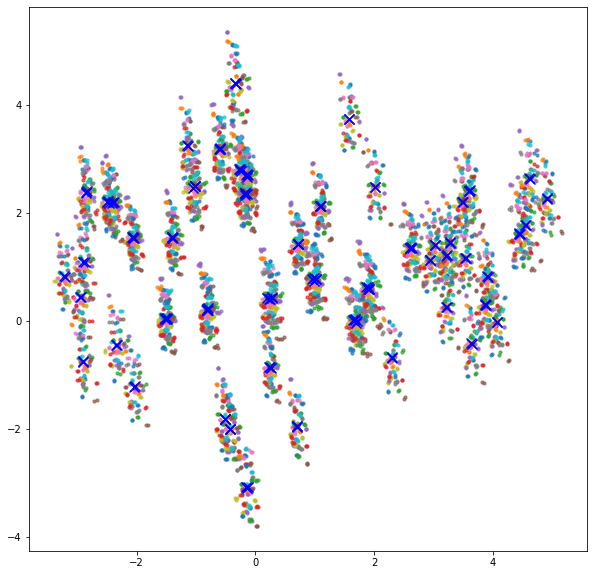

In [6]:
#Open file to save back-projected or source positions
# f_src = open('source_pos.txt', 'w', 0)
# import seaborn as sns
P=len(plummers)
print(P)
N = len(img['x']) #Number of images

defl = np.zeros((2,N,40))
beta = np.zeros((2,N,40))
image = np.zeros(2)
m= [0 for n in range(41)]
m[0]=0
    

factor = 4*G/c**2 #4G/c^2 in cgs
#For loop over images to calculate source positions

fig, ax = plt.subplots(figsize=(10, 10))

for j in range(40):
    m[j+1]=plumno['no'][j]+m[j]
    print(j,end='\r')
    
    for k in range(N):
        image[0],image[1]=img['x'][k],img['y'][k]
        D=d_ls[k]/d_ol[k]/d_os[k]
        defl[0,k,j], defl[1,k,j] = 0., 0.
        for i in range(m[j],m[j+1]):
            defl[0,k,j] += factor*m_sol*pmass[i]*D*(image[0]-px[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2 
            defl[1,k,j] += factor*m_sol*pmass[i]*D*(image[1]-py[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2
            beta[0,k,j], beta[1,k,j]=image[0] - defl[0,k,j], image[1] - defl[1,k,j] #lens equation
    ax.scatter(beta[0,:,j],beta[1,:,j],alpha=0.7,s=10)
#     sns.scatterplot(data=beta)

avgbeta=np.average(beta,axis=2)

ax.scatter(avgbeta[0],avgbeta[1],s=100,color='b',marker='x')


plt.axis()
# plt.legend(loc='upper right')
plt.show()
ax.set_aspect('equal')
fig.savefig('Back_Projected_IrtyshIIIc.pdf', dpi=300)
        
            
            

In [10]:
m= [0 for n in range(41)]
umass=np.zeros((40,2),dtype=(int,float))
lmass=np.zeros((40,2),dtype=(int,float))
mass=np.zeros((40,2),dtype=(int,float))
massr=np.zeros((40,1),dtype=(float))

m[0]=0
for i in range(40):
    m[i+1]=plumno['no'][i]+m[i]
#     print(m[i+1])
    umass[i,0]=i+1
    lmass[i,0]=i+1
    mass[i,0]=i+1
#     massr[i,0]=i+1
    
    for j in range(m[i],m[i+1]):
        mass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]<-8:
            lmass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]>8:
            umass[i,1]+=plummers['mass'][j]
        
    massr[i,0]=(umass[i,1]/lmass[i,1])
# mass=list(enumerate(mass))

In [11]:
del_y = np.zeros((len(img['x']),40,2))
# fig, ax = plt.subplots(figsize=(8,8))
for j in range(40): 
    del_y[:,j,0]=j
    del_y[:,j,1]=(beta[1,:,j] - avgbeta[1,:])#/len(img['x'])
# ax.scatter(del_y[0,:,1],del_y[0,:,0])

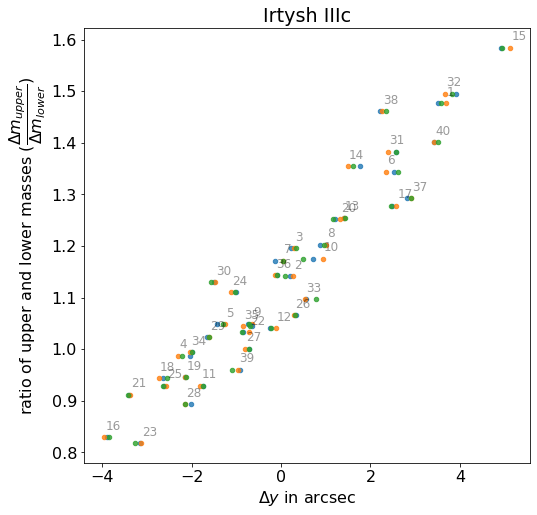

In [13]:
# import pandas as pd

# umass=np.zeros((40,2),dtype=(int,float))

# s=pd.DataFrame(del_y[2,:,1])
# u=pd.DataFrame(massr[0])
# std_y_table=s.sort_values(by=0, ascending=False)
# mass_table=u.sort_values(by=0, ascending=False)

matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(8,8))

for j in range(40):
    ax.scatter(6*del_y[0,j,1],massr[j], color='tab:blue', marker='.',s=80,alpha=0.8)
    ax.scatter(6*del_y[1,j,1],massr[j], color='tab:orange', marker='.',s=80,alpha=0.8)
    ax.scatter(6*del_y[2,j,1],massr[j], color='tab:green', marker='.',s=80,alpha=0.8)
    ax.annotate(j+1,(6*del_y[1,j,1],massr[j]),xytext=(6*del_y[1,j,1]+0.025,massr[j]+0.015),alpha=0.4,fontsize=12)

# plt.scatter(del_y[0,:,1],massr, marker='x')
# plt.scatter(del_y[113,:,1],massr, marker='x')
# plt.scatter(del_y[19,:,1],massr, marker='x')

# z = np.polyfit(del_y[2,:,1], massr, 1)
# xp = np.linspace(0, 10, 100)
# p = np.poly1d(z)
# plt.plot(xp-5, p(xp-5),'g--')

plt.xlabel('$\Delta y$ in arcsec')
plt.ylabel('ratio of upper and lower masses ($\dfrac{\Delta m_{upper}}{\Delta m_{lower}}$)')

plt.title('Irtysh IIIc')

plt.show()

fig.savefig('/Users/agnivaghosh/Downloads/Lensing/magnifications/plots/outermass_IrtyshIIIc_src1.pdf', dpi=900, transparent=True,bbox_inches='tight')


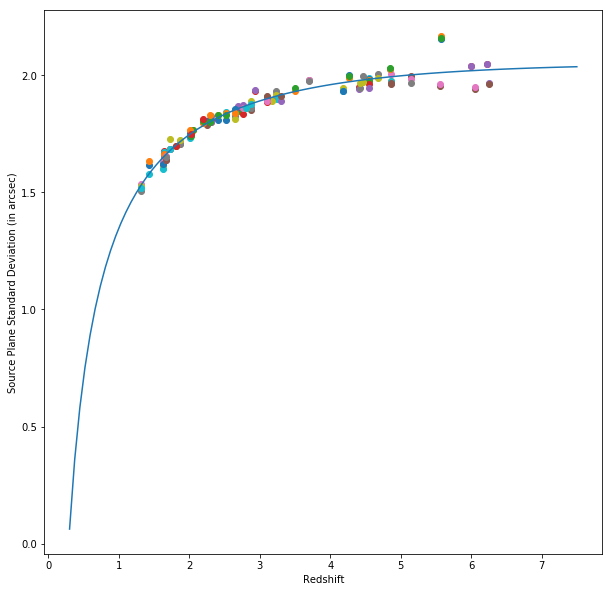

In [37]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(img['z'][i],6*std[i])
    
    
z = np.polyfit(np.log10(img['z']), 6*std, 3)
xp = np.linspace(0.3, 7.5, 100)
p = np.poly1d(z)
plt.plot(xp, p(np.log10(xp)))
# plt.axis([0.1,10,0,0.2])
# plt.yscale('log')
plt.xlabel("Redshift")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()
fig.savefig('SPsd_IrtyshIa.pdf', dpi=300, transparent=True,bbox_inches='tight')



In [12]:
len(std)

151

In [ ]:
std_src = np.zeros((2,40))
std=np.zeros(40)

for i in range(40):
    std_src[0,i]=np.sqrt(np.mean(abs(beta[0,:,i] - avgbeta[0,:])**2))
    std_src[1,i]=np.sqrt(np.mean(abs(beta[0,:,i] - avgbeta[0,:])**2))
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)


In [ ]:
std

In [ ]:
import pandas as pd
s=pd.DataFrame(std)
print(s.sort_values(by=0, ascending=False))
s.dtypes